In [ ]:
!pip install --upgrade openpyxl

Saving GrandErie-EcoleConfederation-DuctSealing_1646767265.xlsx to GrandErie-EcoleConfederation-DuctSealing_1646767265 (1).xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

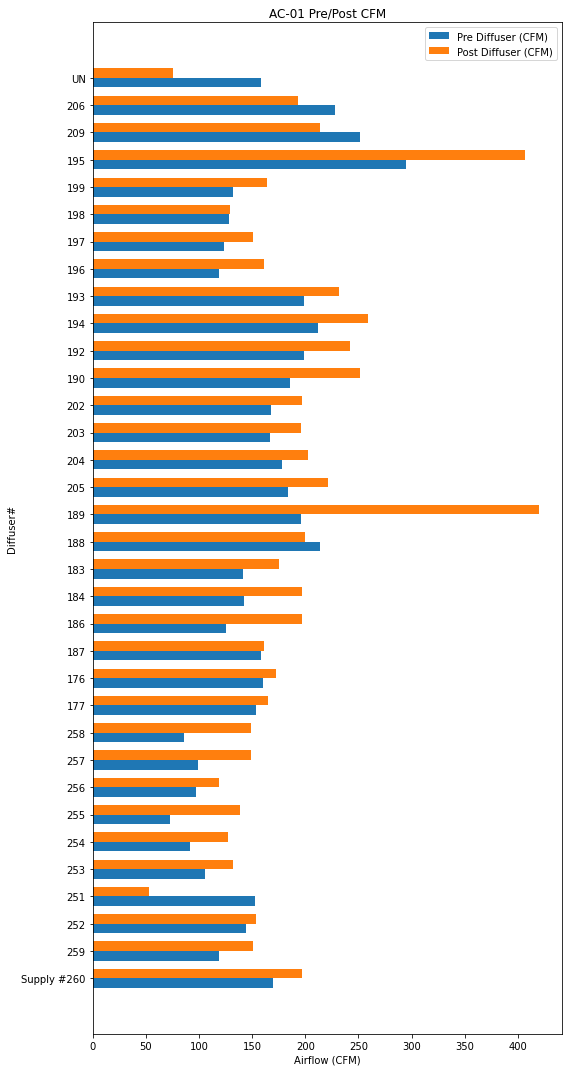

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

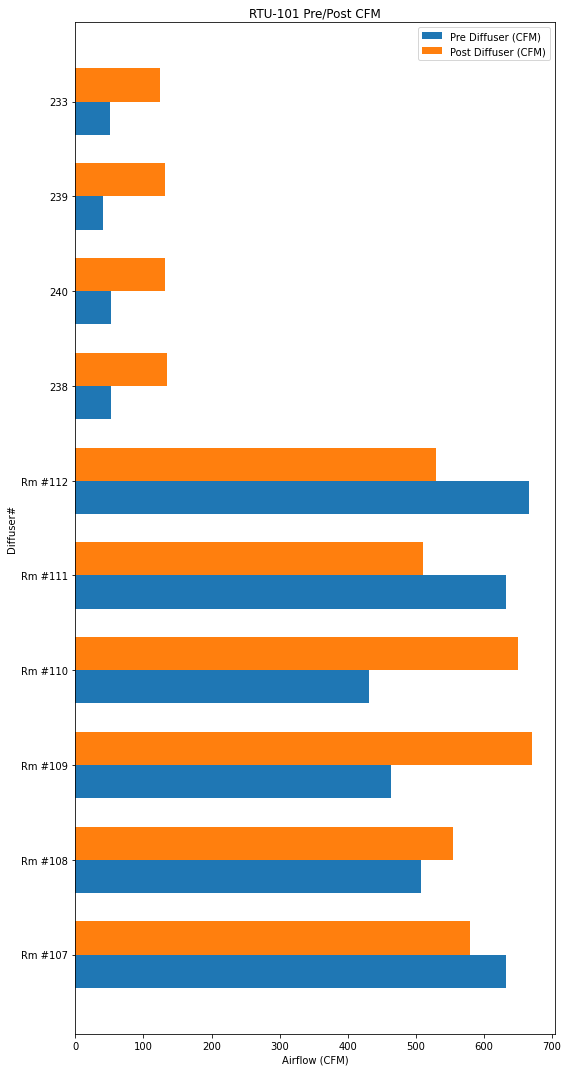

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [132]:
# import library
import pandas as pd
from google.colab import files
import io
import matplotlib.pyplot as plt
import numpy as np
# upload files
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_excel(io.BytesIO(uploaded[filename]))
# define column names, same as subitems on Monday.com project board 
col = ['Subitems', 'Name', 'Confirmed','Pre Diffuser (CFM)', 'Post Diffuser (CFM)']
# drop columns where all of the elements are nan
dfClean = df.dropna(axis=1, how='all')
# get unit subitem start index and create dataframe
# use "Subitems" in the 1st columns as indicator
# if it's true, add it to list
unitSubClnIdx = dfClean.index[df.iloc[:,0]== "Subitems"].tolist()
# find subitem columns and use that as dataframe columns
dfClean.columns = dfClean.iloc[unitSubClnIdx[0],:]
# select columns matching 'col'
dfClean = dfClean[col]
# rename 'Name' column as 'diffuser'
dfClean = dfClean.rename(columns={'Name': 'Diffuser #'})
# map(function, iterable) to get unit name index
# list() to transfer map object to list
unitNmIdx = list(map(lambda x: x-1, unitSubClnIdx))
unitSubStIdx = list(map(lambda x: x+1, unitSubClnIdx))
# print('unit name index: ', unitNmIdx)
# print('unit subitem column index: ', unitSubClnIdx)
# print('unit subitem start index: ', unitSubStIdx)


def unit_name_list (unitNmIdx, dfClean):
  units = []
  for i in range(0,len(unitNmIdx)):
    # get unit name
    unitNm = dfClean.iloc[unitNmIdx[i],0]
    # append items into units list
    units.append(unitNm) 
  return units

def unit_dataframe_list(unitSubStIdx, unitNmIdx, dfClean):
  unit_dataframe_list = []
  # for loop within total number of units
  # i starts from 0
  for i in range(0,len(unitSubStIdx)):
    # if unit is not the last one in the dataframe
    if i < len(unitSubStIdx)-1:
      # slice the dataframe from the first index of ith unit to the one index before i+1th unit
      # select all columns
      df_i = dfClean.iloc[unitSubStIdx[i] : unitNmIdx[i+1] ,:]
      # if unit is the last one in the dataframe
    else:
      # slice the dataframe from the first index of the unit to the last index of the unit
      # last row of input datafram has redundant information, use -1 to exclude
      # select all columns
      df_i = dfClean.iloc[unitSubStIdx[i] : -1 ,:]
    # add dataframe into the list
    unit_dataframe_list.append(df_i)
  return unit_dataframe_list

def CFM_Improvement_Analysis_CSV_list(unit_name_list, unit_dataframe_list):
  CFM_Improvement_Analysis_list = []
  # for loop dataframe in the list
  for i in range(0, len(unit_dataframe_list)):
    # pick ith dataframe
    df_i = unit_dataframe_list[i]
    filename_i = unit_name_list[i]
    # drop na rows in 'Post Diffuser (CFM)' column to get CFM reading data only
    df_i = df_i[df_i['Post Diffuser (CFM)'].notna()]
    # drop 'Confirmed' column (axis=1)
    df_i = df_i.drop(['Confirmed'], axis=1)
    df_i = df_i.rename(columns={'Subitems': unit_name_list[i]})
    # replace '0' value in Pre-seal CFM with mean. Round to the nearest integer
    df_i['Pre Diffuser (CFM)']=df_i['Pre Diffuser (CFM)'].replace(0,round(df_i['Pre Diffuser (CFM)'].mean()))
    # replace null value in Pre-seal CFM with mean. Round to the nearest integer
    df_i['Pre Diffuser (CFM)'] = df_i['Pre Diffuser (CFM)'].fillna(round(df_i['Pre Diffuser (CFM)'].mean()))
    # add total value row for Pre-diffuser, Post-diffuser with iloc slicing
    df_i.loc['Total'] = df_i.iloc[:, 2:].sum()
    # add columns for improvement %
    df_i['% Improvement'] = (df_i['Post Diffuser (CFM)']-df_i['Pre Diffuser (CFM)'])/df_i['Pre Diffuser (CFM)']
    df_i['% Improvement'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df_i['% Improvement']], index = df_i.index)
    df_i['Diffuser #'] = df_i['Diffuser #'].astype(str)
    df_i.iloc[-1, df_i.columns.get_loc('Diffuser #')] = 'Total'
    df_i.reset_index(drop=True, inplace=True)
    CFM_Improvement_Analysis_list.append(df_i)
    #Download csv
    from google.colab import files
    newFilename=filename.replace('.xlsx', '')
    df_i.to_csv(newFilename + filename_i +'cleaned.csv') 
    files.download(newFilename + filename_i +'cleaned.csv')
    

  return CFM_Improvement_Analysis_list

def Plot(CFM_Improvement_Analysis_CSV_list, unit_name_list):
  for i in range(0, len(CFM_Improvement_Analysis_CSV_list)):
    filename_i = unit_name_list[i]
    df_i = CFM_Improvement_Analysis_CSV_list[i]
    df_iChart=df_i.drop(df_i.tail(1).index)
    labels = df_iChart['Diffuser #']
    PreDiffuserCFM = df_iChart['Pre Diffuser (CFM)']
    PostDiffuserCFM = df_iChart['Post Diffuser (CFM)']
    ChartName = filename_i + ' Pre/Post CFM'

    y = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    plt.rcParams["figure.figsize"] = (8,15)
    fig, ax = plt.subplots()
    rects1 = ax.barh(y - width/2, PreDiffuserCFM, width, label='Pre Diffuser (CFM)')
    rects2 = ax.barh(y + width/2, PostDiffuserCFM, width, label='Post Diffuser (CFM)')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Diffuser#')
    ax.set_xlabel('Airflow (CFM)')
    ax.set_title(ChartName)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

    #Download png
    dfChartname = filename_i + '.png'
    fig.savefig(dfChartname, dpi=fig.dpi)
    files.download(dfChartname)  
  
  return(ax)

unit_name_list = unit_name_list(unitNmIdx, dfClean)
unit_dataframe_list = unit_dataframe_list(unitSubStIdx, unitNmIdx, dfClean)
CFM_Improvement_Analysis_CSV_list = CFM_Improvement_Analysis_CSV_list(unit_name_list, unit_dataframe_list)
Plot(CFM_Improvement_Analysis_CSV_list, unit_name_list)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

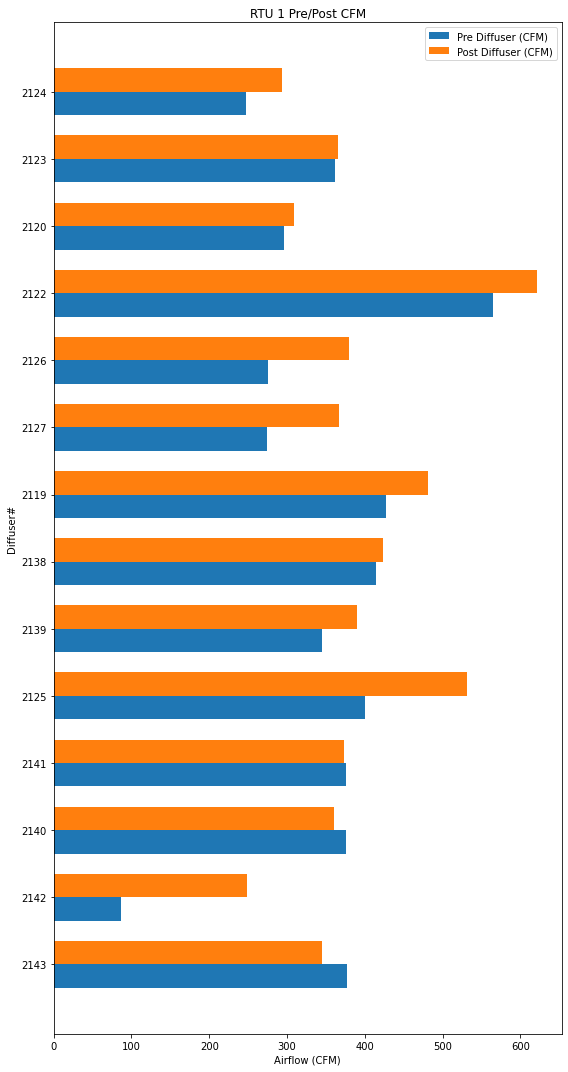

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

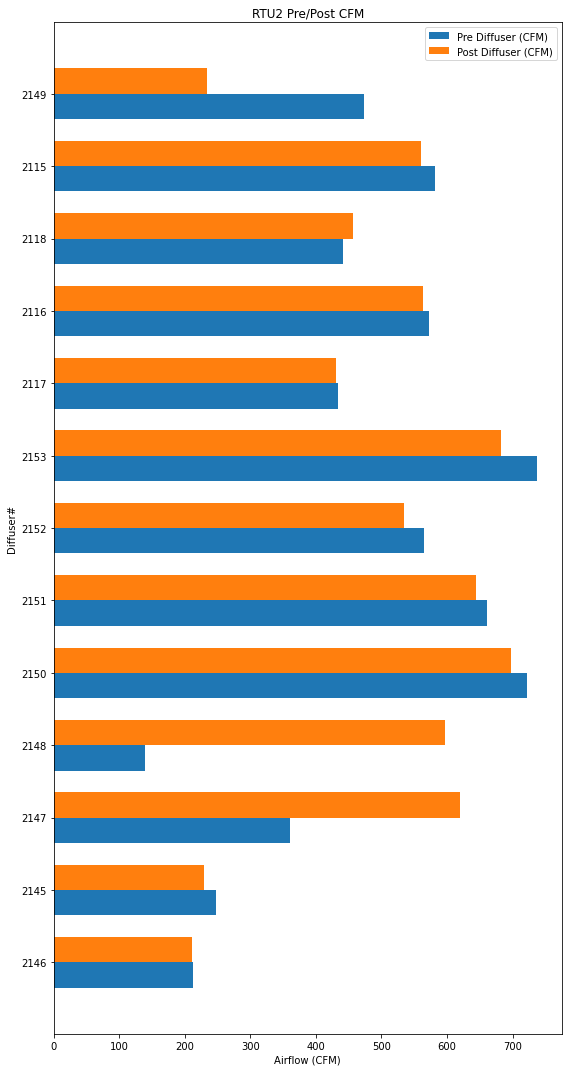

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

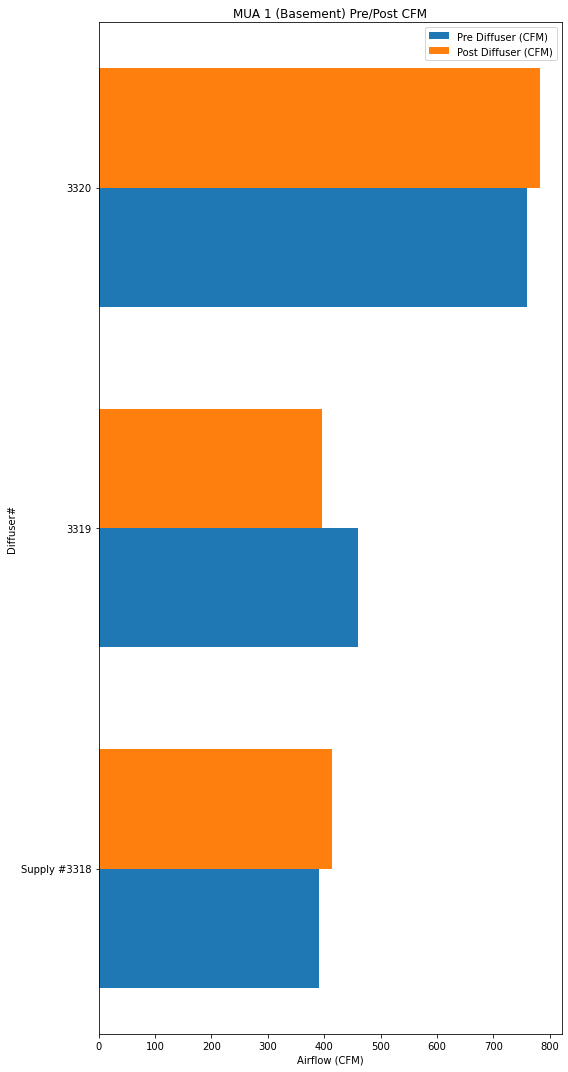

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>